In [1]:
import numpy as np
import xarray as xr
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('./grl.mplstyle')

# from windwave.defs import Case, Interface2D
# from windwave.prepare import read_p, read_fields

%load_ext autoreload
%autoreload 3

In [ ]:
''' Read in the slices and construct the xarray dataset. '''

def read_fields_3D (path, t, NSLICE=256, NGRID=512, varlist=['ux','uy','uz','f']):

    # Check if the netcdf file already exist
    filename = path + 'netcdf/field_t%g.nc' %t 
    
    if os.path.exists(filename):
        print('NetCDF file exist! Located at ' + filename)
        ds = xr.open_dataset(filename, engine='netcdf4', decode_cf=True)
    
    else:
        # if not construct new xarray dataset
        # axis0 in z, axis1 in x, axis2 in y  (in the code)
        print('Reading t=%g slices...' %t)
        x = np.linspace(-np.pi, np.pi, NGRID, endpoint=False) + 2*np.pi/NGRID/2
        y = np.linspace(0, 2*np.pi, NGRID, endpoint=False) + 2*np.pi/NGRID/2
        z = np.linspace(-np.pi, np.pi, NSLICE, endpoint=False) + 2*np.pi/NSLICE/2
        
        # TODO: write read in eta file
        # ...

        # read in slices
        for i, var in enumerate(varlist):   
            field = []
            # NOTICE: since 2024/07 we have fixed z slices so (0, NSLICE) instead of (0, NSLICE-1)
            for sn in range (0, NSLICE):
                slicename = path + 'field/' + var + '_t%g_slice%g' % (t,sn)
                snapshot = np.fromfile(slicename, dtype=np.float64)
                snapshot = snapshot.reshape([NGRID,NGRID])
                field.append(snapshot)
            field = np.array(field)
            if i == 0:
                ds = xr.Dataset({var: (['z','x','y'], field)}, coords={'x': x, 'y': y, 'z': z})
            else:
                ds = ds.assign(**{var: (['z','x','y'], field)})
                
        # Writing to file with some compression
        encoding = {}
        for var_name in ds.data_vars:
            encoding[var_name] = {'dtype': 'float32', 'zlib': True}
        ds.to_netcdf(filename, encoding=encoding)

    # Shift the values along x axis
    # field['value'] = np.roll(field['value'], -idx, axis=1)
    return ds

In [ ]:
# path_NWP = '/home/ctrsp-2024/jiarongw/outputs/test_NWP/'
# ds_NWP = read_fields_3D(path_NWP, t=39.5, NSLICE=512, NGRID=512, varlist=['ux','uy','uz','f'])

path = '/home/ctrsp-2024/jiarongw/outputs/CU4/'
times = np.arange(43.3,44.8,0.1)
for t in times:
    ds = read_fields_3D(path, t=t, NSLICE=512, NGRID=512, varlist=['ux','uy','uz','f'])

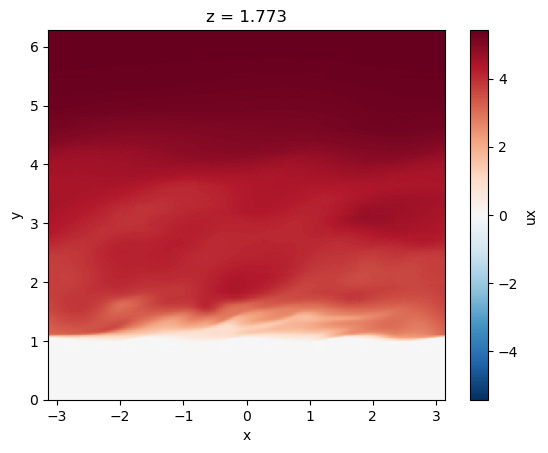

In [14]:
ds.ux.isel(z=400).plot(x='x')

Text(0, 0.5, 'Horizontal flux')

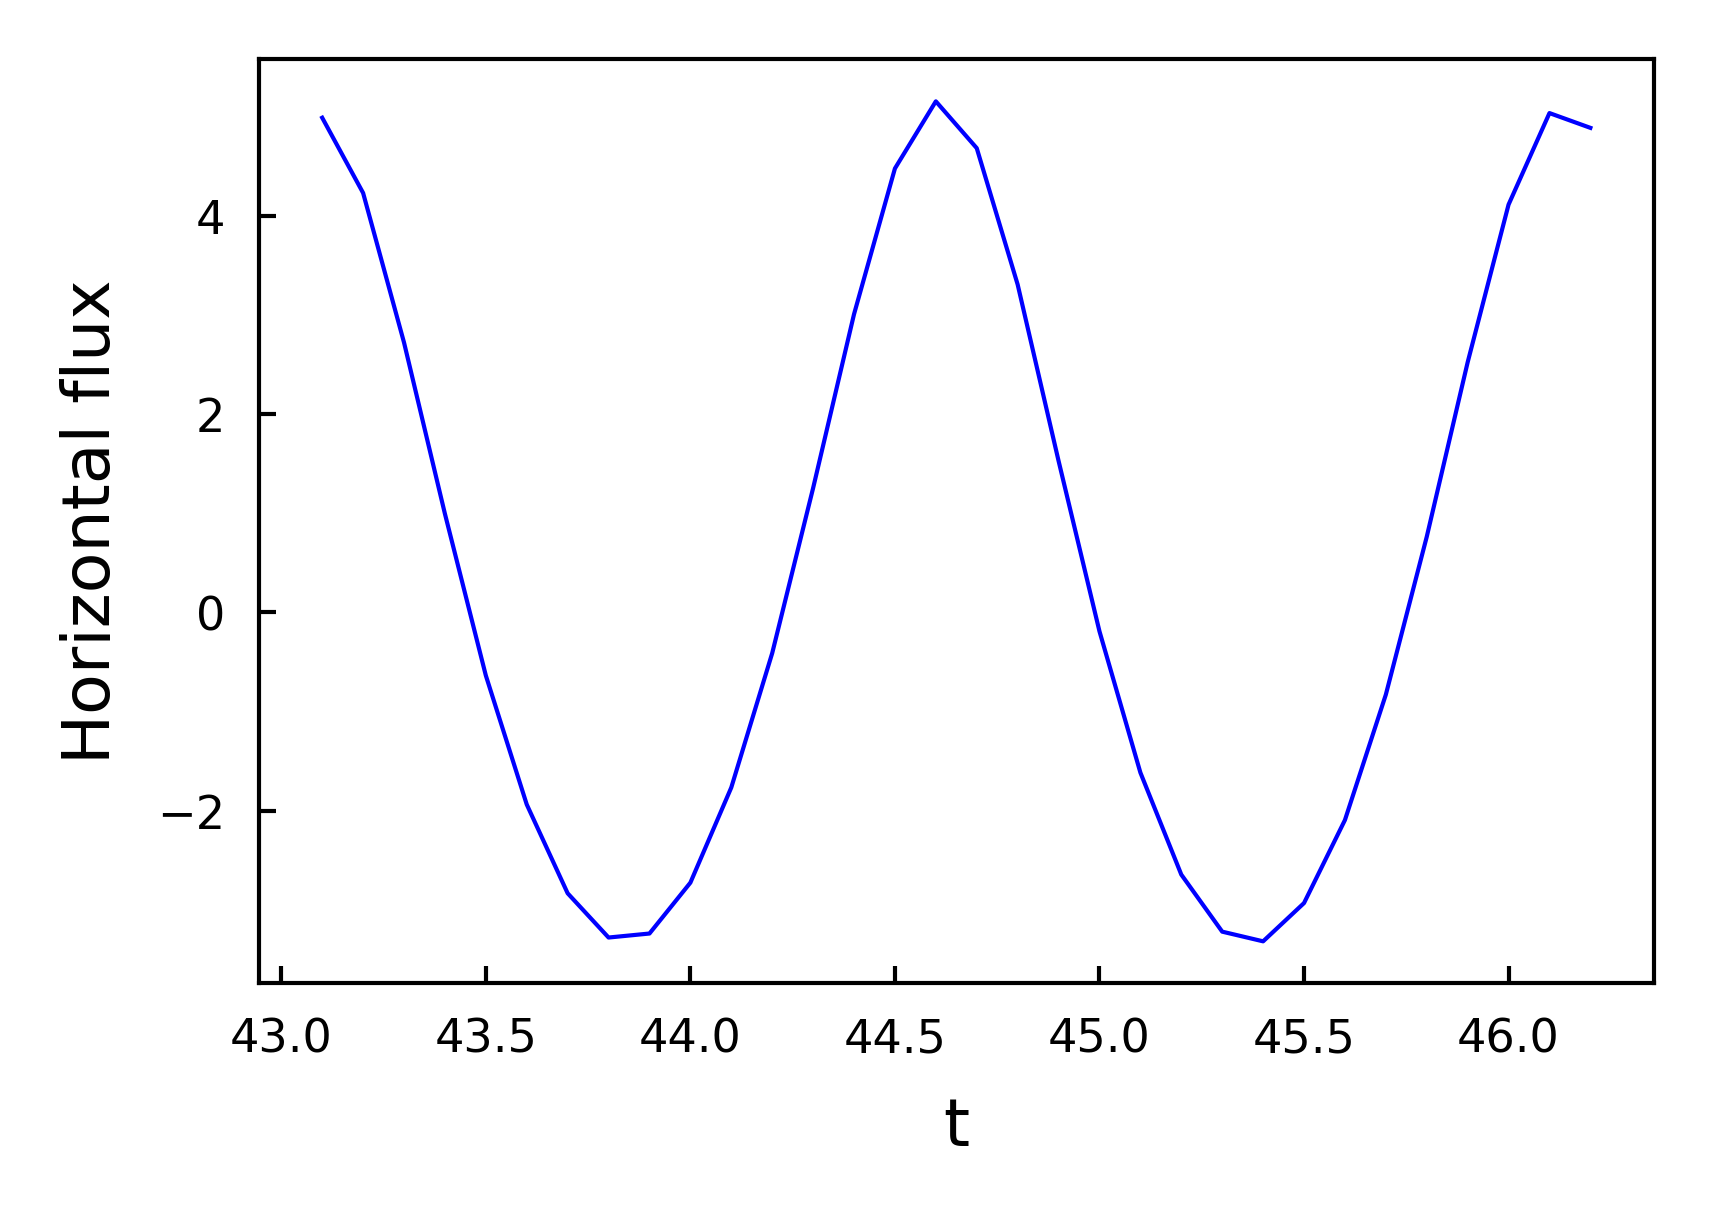

In [92]:
''' Whether there is a mean inflow. '''
uxw = ds.ux*ds.f
inflow = uxw.isel(x=0).sum(dim='y')
fig = plt.figure(figsize=[3,2]); ax = plt.gca()
inflow.plot()
ax.set_title('')
ax.set_ylabel('Horizontal flux')